In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from math import pi
import plotly.graph_objects as go
from main import calculate_similarities_mat
import gzip

Matplotlib is building the font cache; this may take a moment.


In [51]:
df = pd.read_csv('account_level_modified.csv.gz')
group1 = ['google', 'amazon', 'facebook', 'apple', 'microsoft']
group2 = ['ibm', 'tencent', 'intel', 'samsung', 'alibaba']
group3 = ['openai', 'nvidia', 'huawei', 'salesforce', 'baidu']
group4 = df[~df['account_name'].isin(group1 + group2 + group3)]['account_name'].unique().tolist()

def assign_group(account_name):
    if account_name in group1:
        return 'Group 1'
    elif account_name in group2:
        return 'Group 2'
    elif account_name in group3:
        return 'Group 3'
    else:
        return 'Group 4'

df['group'] = df['account_name'].apply(assign_group)

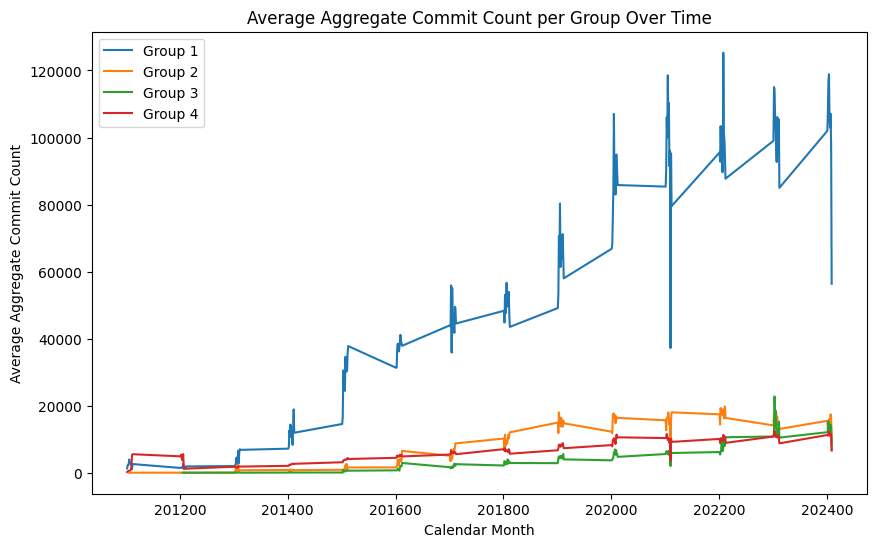

In [3]:
#Line Chart for Average Quality Metrics per Group
quality_metrics = ['aggregate_commit_count', 'repository_count', 'star_count']
df_grouped = df.groupby(['group', 'calendar_month'])[quality_metrics].mean().reset_index()

plt.figure(figsize=(10, 6))
for group in ['Group 1', 'Group 2', 'Group 3', 'Group 4']:
    group_data = df_grouped[df_grouped['group'] == group]
    plt.plot(group_data['calendar_month'], group_data['aggregate_commit_count'], label=group)

plt.xlabel('Calendar Month')
plt.ylabel('Average Aggregate Commit Count')
plt.title('Average Aggregate Commit Count per Group Over Time')
plt.legend()
plt.show()

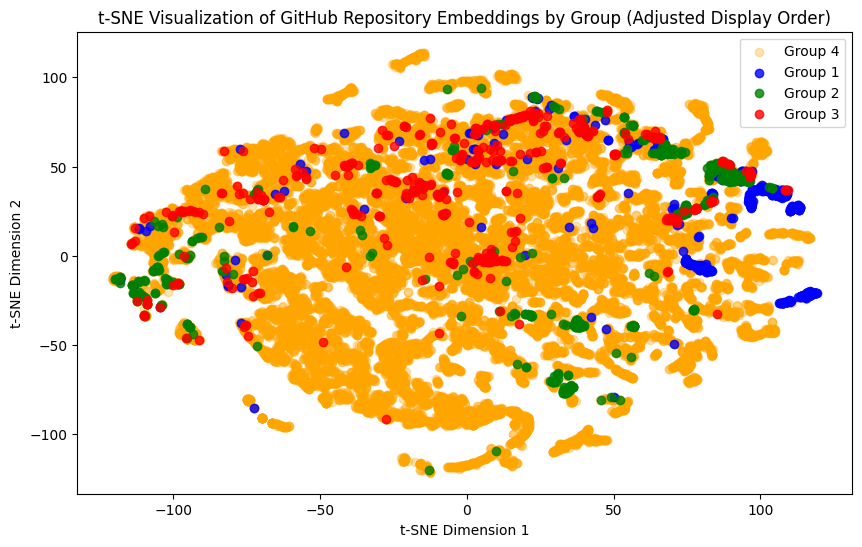

In [12]:
#t-SNE Dimensionality Reduction for Embeddings
#Define the metadata features for embeddings(can select specific features to do visualization)
features = [
    'aggregate_commit_count', 'repository_count', 'contributor_count', 
    'fork_count', 'star_count', 'pull_request_closures_count', 
    'pull_request_accepted_count', 'issues_created_count', 
    'issues_closed_count', 'releases_count', 'external_contribution_ratio'
]
# Check if all features exist in dataset
missing_features = [feature for feature in features if feature not in df.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(df[features])

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    df['tsne_dim1'] = embeddings_2d[:, 0]
    df['tsne_dim2'] = embeddings_2d[:, 1]

    plt.figure(figsize=(10, 6))
    colors = {'Group 1': 'blue', 'Group 2': 'green', 'Group 3': 'red', 'Group 4': 'orange'}

    subset = df[df['group'] == 'Group 4']
    plt.scatter(subset['tsne_dim1'], subset['tsne_dim2'], label='Group 4', alpha=0.3, c='orange')

    for group, color in [('Group 1', 'blue'), ('Group 2', 'green'), ('Group 3', 'red')]:
        subset = df[df['group'] == group]
        plt.scatter(subset['tsne_dim1'], subset['tsne_dim2'], label=group, alpha=0.8, c=color)

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of GitHub Repository Embeddings by Group (Adjusted Display Order)')
    plt.legend()
    plt.show()


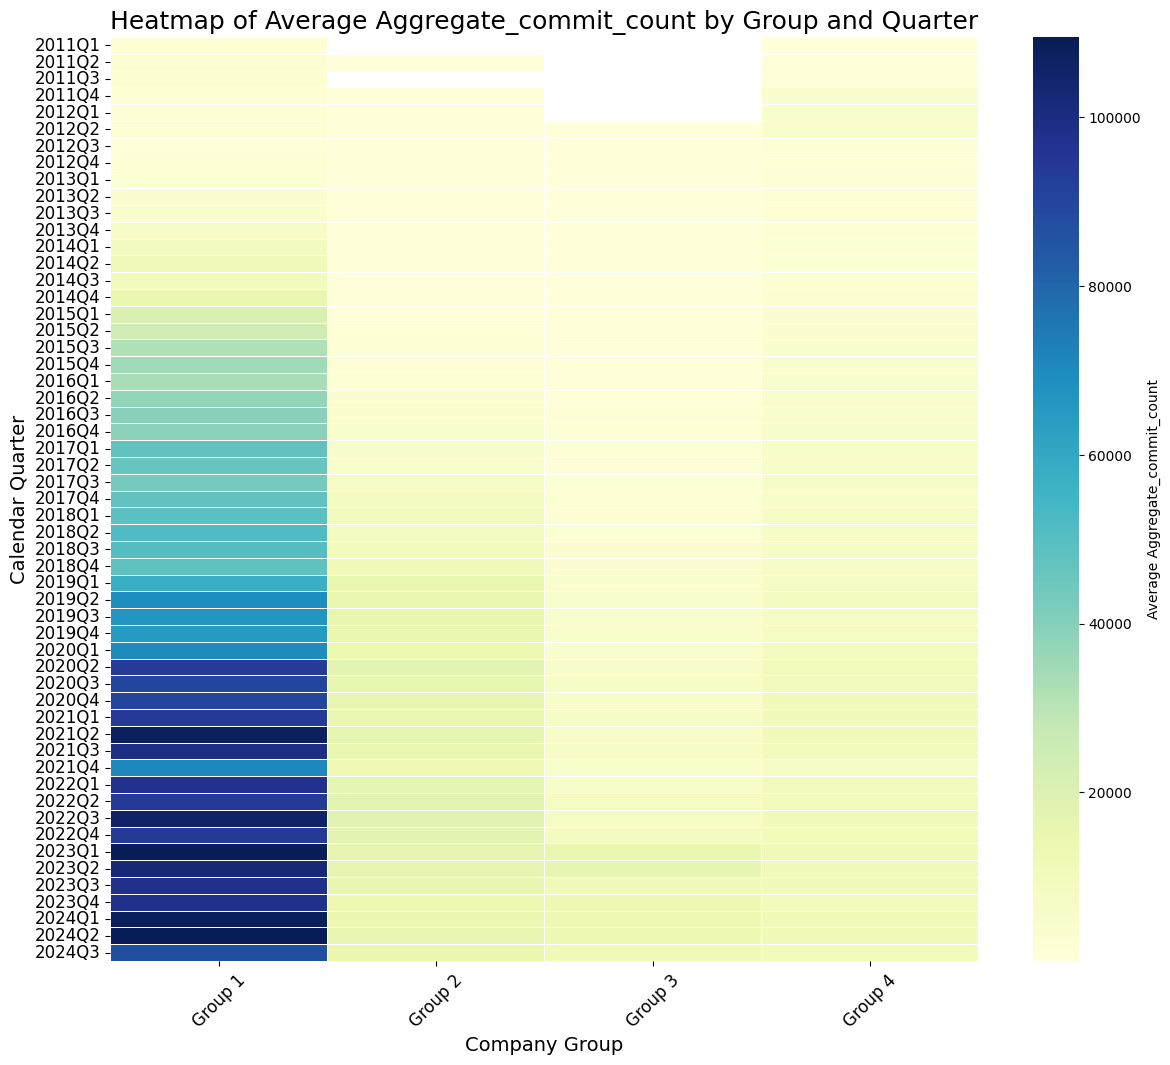

In [22]:
#Heatmap of quality metrics among company groups
df['calendar_month'] = pd.to_datetime(df['calendar_month'], format='%Y%m')
df['calendar_quarter'] = df['calendar_month'].dt.to_period('Q')

metric = 'aggregate_commit_count'
df_grouped = df.groupby(['calendar_quarter', 'group'])[metric].mean().reset_index()

heatmap_data = df_grouped.pivot_table(index='calendar_quarter', columns='group', values=metric)

plt.figure(figsize=(14, 12))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='white', cbar_kws={'label': f'Average {metric.capitalize()}'})
plt.title(f'Heatmap of Average {metric.capitalize()} by Group and Quarter', fontsize=18)
plt.xlabel('Company Group', fontsize=14)
plt.ylabel('Calendar Quarter', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

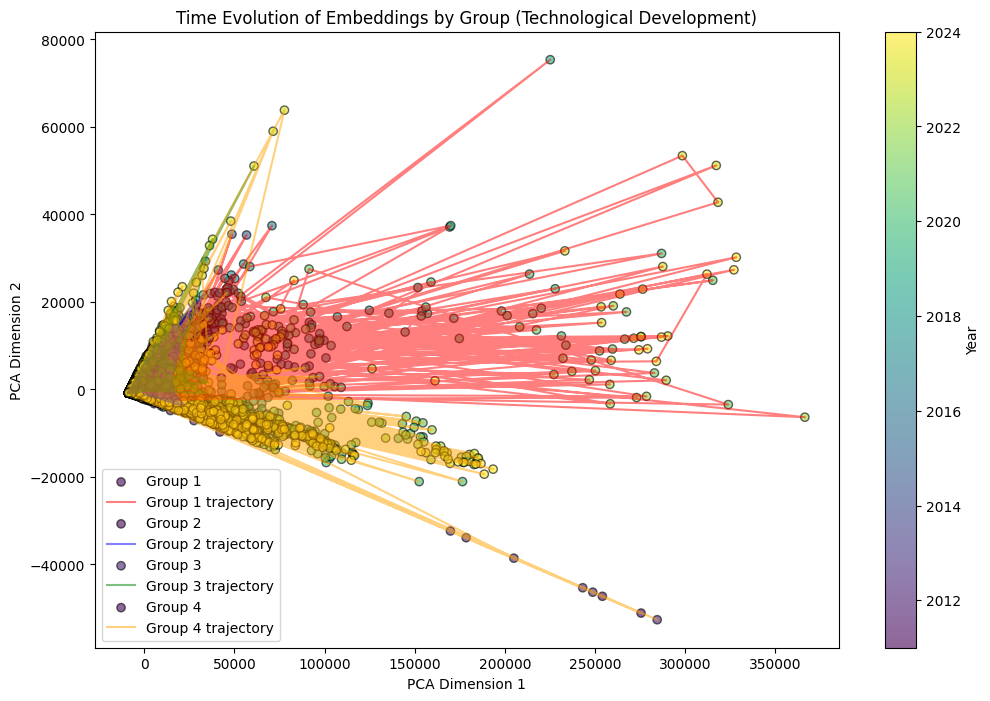

In [41]:
#time evolution trajectories based on groups (Embedding Time Series Plot)
df['calendar_month'] = pd.to_datetime(df['calendar_month'], format='%Y%m')

if all(feature in df.columns for feature in features):
    embeddings = df[features].values

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    df['pca_dim1'] = embeddings_2d[:, 0]
    df['pca_dim2'] = embeddings_2d[:, 1]

    plt.figure(figsize=(12, 8))

    time_periods = df['calendar_month'].unique()
    cmap = plt.get_cmap('viridis')
    
    min_year = df['calendar_month'].dt.year.min()
    max_year = df['calendar_month'].dt.year.max()
    norm = plt.Normalize(vmin=min_year, vmax=max_year)

    group_colors = {
        'Group 1': 'red',
        'Group 2': 'blue',
        'Group 3': 'green',
        'Group 4': 'orange'
    }

    for group in ['Group 1', 'Group 2', 'Group 3', 'Group 4']:
        group_data = df[df['group'] == group]
        group_data = group_data.sort_values('calendar_month')
        
        time_values = group_data['calendar_month'].dt.year
        colors = cmap(norm(time_values))

        scatter = plt.scatter(group_data['pca_dim1'], group_data['pca_dim2'], c=time_values, cmap='viridis', alpha=0.6, edgecolor='k', norm=norm, label=group)

        plt.plot(group_data['pca_dim1'], group_data['pca_dim2'], color=group_colors[group], alpha=0.5, label=f'{group} trajectory')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Year')

    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.title('Time Evolution of Embeddings by Group (Technological Development)')
    plt.legend()
    plt.show()
else:
    print("One or more selected features are missing in the DataFrame.")

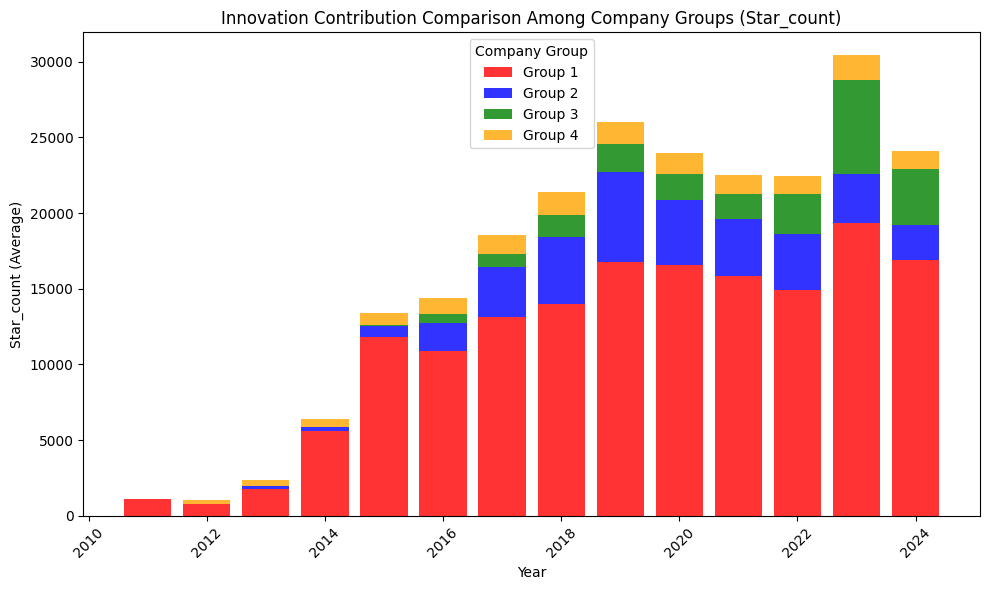

In [43]:
#Innovation contribution comparison among company groups
df['calendar_month'] = pd.to_datetime(df['calendar_month'], format='%Y%m')

df['calendar_year'] = df['calendar_month'].dt.year

key_metric = 'star_count'

grouped_data = df.groupby(['group', 'calendar_year'])[key_metric].mean().reset_index()

grouped_pivot = grouped_data.pivot(index='calendar_year', columns='group', values=key_metric)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red', 'blue', 'green', 'orange']

group_names = grouped_pivot.columns
bottom_values = np.zeros(len(grouped_pivot))
for i, group in enumerate(group_names):
    ax.bar(grouped_pivot.index, grouped_pivot[group], bottom=bottom_values, label=group, color=colors[i], alpha=0.8)
    bottom_values += grouped_pivot[group]

ax.set_xlabel('Year')
ax.set_ylabel(f'{key_metric.capitalize()} (Average)')
ax.set_title(f'Innovation Contribution Comparison Among Company Groups ({key_metric.capitalize()})')
ax.legend(title='Company Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

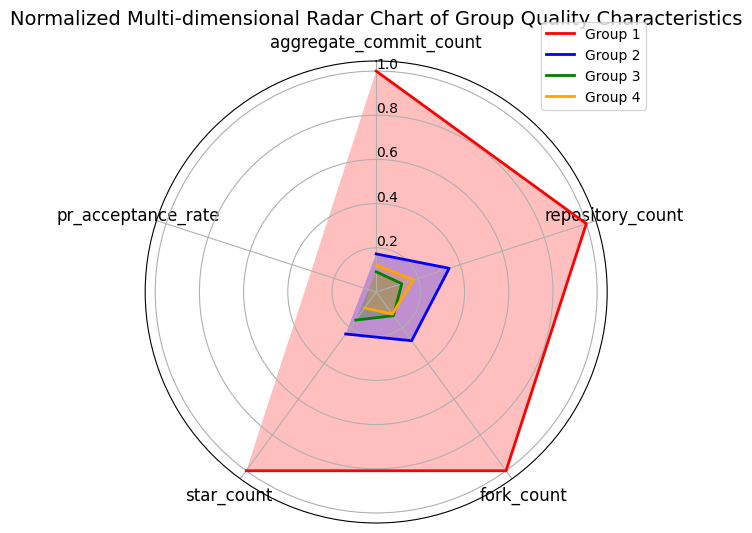

In [47]:
#multi-dimensional radar chart to display quality characteristics
df['pr_acceptance_rate'] = df['pull_request_accepted_count'] / df['pull_request_closures_count']
metrics = ['aggregate_commit_count', 'repository_count', 'fork_count', 'star_count', 'pr_acceptance_rate']

grouped_data = df.groupby('group')[metrics].mean().reset_index()

for metric in metrics:
    grouped_data[metric] = grouped_data[metric] / grouped_data[metric].max()

categories = metrics
N = len(categories)

def create_radar_chart(ax, group_data, label, color):
    values = group_data.tolist()
    values += values[:1] 
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    ax.set_rlabel_position(0)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=label, color=color)
    ax.fill(angles, values, color=color, alpha=0.25)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, group in enumerate(grouped_data['group']):
    group_data = grouped_data.loc[i, metrics]
    create_radar_chart(ax, group_data, label=group, color=colors[i])

plt.title('Normalized Multi-dimensional Radar Chart of Group Quality Characteristics', size=14)
ax.set_xticks([n / float(N) * 2 * pi for n in range(N)])
ax.set_xticklabels(categories, size=12)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

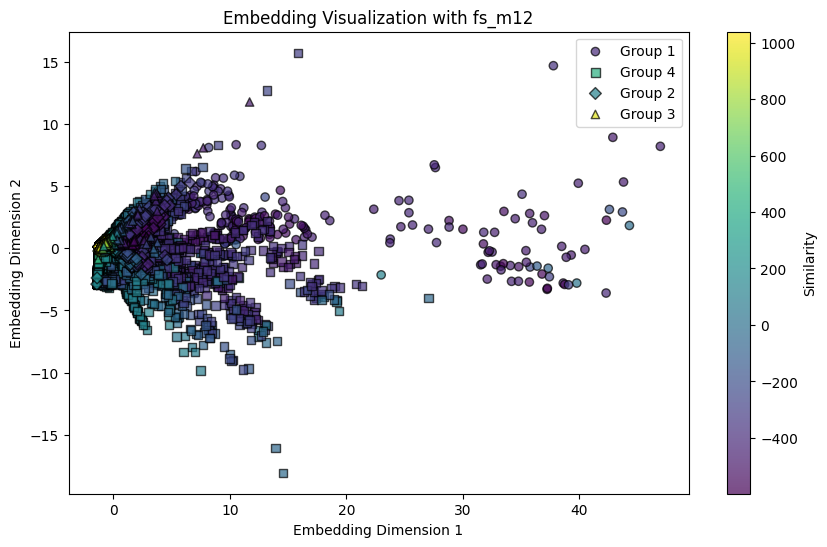

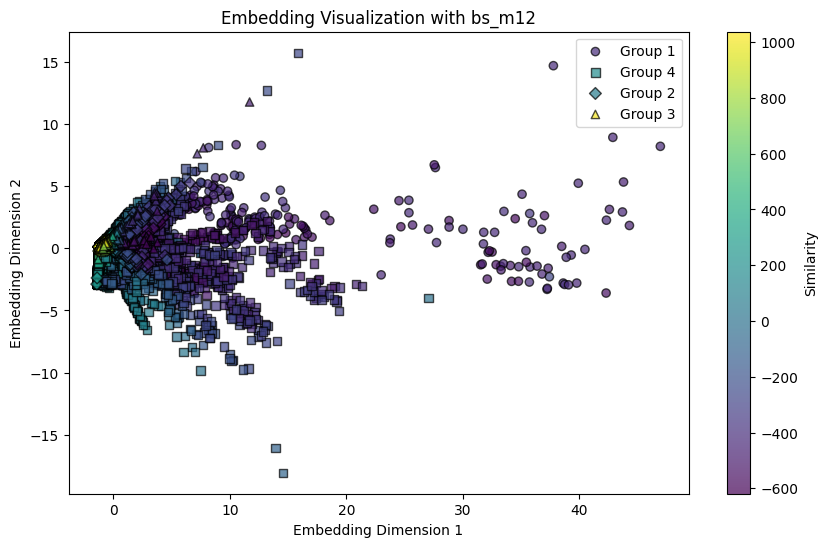

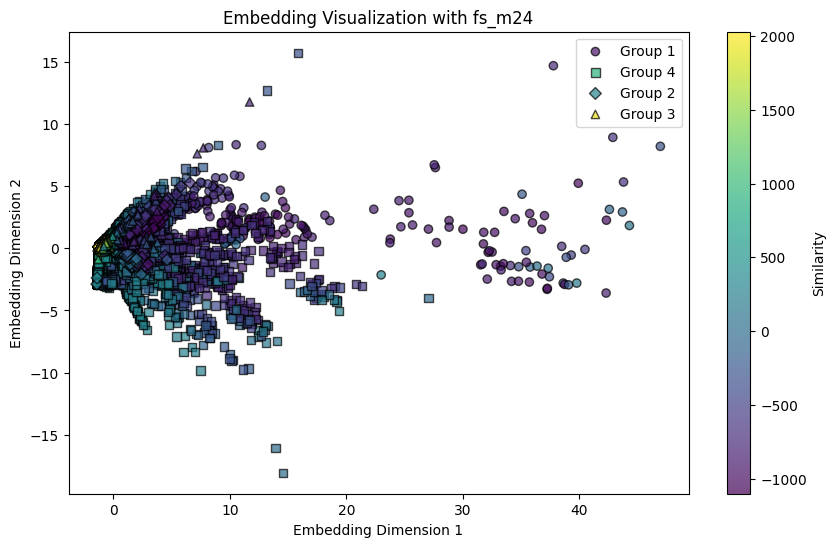

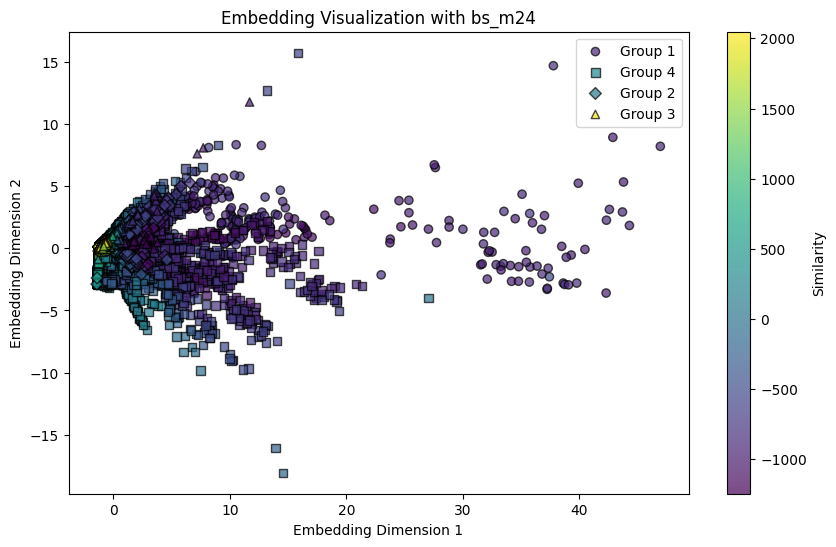

In [72]:
def calculate_similarities(df, time_period_months):
    df['date'] = pd.to_datetime(df['calendar_month'], format='%Y%m')
    df[f'fs_m{time_period_months}'] = np.nan
    df[f'bs_m{time_period_months}'] = np.nan

    embeddings_matrix = np.vstack(df['embedding'].values)
    norms = np.linalg.norm(embeddings_matrix, axis=1)

    for i in range(len(df)):
        curr_emb = embeddings_matrix[i]
        curr_norm = norms[i]
        curr_date = df.at[i, 'date']

        forward_time = curr_date + pd.DateOffset(months=time_period_months)
        backward_time = curr_date - pd.DateOffset(months=time_period_months)

        forward_idx = df[(df['date'] > curr_date) & (df['date'] <= forward_time)].index
        forward_embs = embeddings_matrix[forward_idx]
        backward_idx = df[(df['date'] < curr_date) & (df['date'] >= backward_time)].index
        backward_embs = embeddings_matrix[backward_idx]

        if len(forward_embs) > 0:
            forward_similarities = np.dot(forward_embs, curr_emb) / (norms[forward_idx] * curr_norm)
            forward_similarity = np.sum(forward_similarities)
        else:
            forward_similarity = 0

        if len(backward_embs) > 0:
            backward_similarities = np.dot(backward_embs, curr_emb) / (norms[backward_idx] * curr_norm)
            backward_similarity = np.sum(backward_similarities)
        else:
            backward_similarity = 0

        df.at[i, f'fs_m{time_period_months}'] = forward_similarity
        df.at[i, f'bs_m{time_period_months}'] = backward_similarity

    return df

def visualize_embeddings_with_similarity_grouped(df, similarity_col):
    plt.figure(figsize=(10, 6))

    markers = ['o', 's', 'D', '^']
    groups = df['group'].unique()

    for i, group in enumerate(groups):
        group_df = df[df['group'] == group]
        sc = plt.scatter(group_df['embedding_dim1'], group_df['embedding_dim2'],
                         c=group_df[similarity_col], cmap='viridis', alpha=0.7, 
                         marker=markers[i], edgecolor='k', label=f'{group}')
    
    plt.colorbar(sc, label='Similarity')
    plt.title(f'Embedding Visualization with {similarity_col}')
    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.legend(loc='upper right')
    plt.show()

missing_features = [feature for feature in features if feature not in df.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    embeddings = scaler.fit_transform(df[features])

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    df['embedding_dim1'] = embeddings_2d[:, 0]
    df['embedding_dim2'] = embeddings_2d[:, 1]
    df['embedding'] = embeddings.tolist()

    df = calculate_similarities(df, 12)
    df = calculate_similarities(df, 24)

    visualize_embeddings_with_similarity_grouped(df, similarity_col='fs_m12')
    visualize_embeddings_with_similarity_grouped(df, similarity_col='bs_m12')

    visualize_embeddings_with_similarity_grouped(df, similarity_col='fs_m24')
    visualize_embeddings_with_similarity_grouped(df, similarity_col='bs_m24')